In [1]:
using LinearAlgebra
using Dierckx
using Optim
using Plots
using DelimitedFiles
using LaTeXStrings

In [2]:
include("Utils.jl")
include("Models.jl")
include("BellmanEq.jl")

BellmanEq (generic function with 1 method)

In [3]:
function ndp(m::Models)
    """
    状態変数のみ離散化して操作変数は連続的に値を取る場合の動的計画法(parametric DP)の解法.
    アルゴリズムの詳細は、Johnson et al. (1993)を参照
    
    # Arguments
    `m::Models`: パラメータ等を含む構造体
    
    # Returns
    `vfcn0::Vector{Float64}`: 計算によって得られた価値関数
    `pfcn1::Vector{Float64}`: 計算によって得られた政策関数
    """
    #　価値関数と政策関数の初期化
    
    pfcn0 = zeros(m.nk) #単純な計算には不要 プロットのためだけに用意
    vfcn0 = Utils.CRRA.(m.kgrid.^m.α + (1- m.δ)* m.kgrid, m.γ)
    
    pfcn1 = similar(pfcn0) # pfcn0を入れない場合は zeros(m.nk)で初期化
    vfcn1 = similar(pfcn1) 
    
    # 利用可能な資産をあらかじめ計算しておく
    wealth =  m.kgrid.^m.α + (1 - m.δ) * m.kgrid
    
    # 繰り返し誤差を保存する変数を設定 
    # 途中経過を図示する目的なので、通常は不要(むしろ遅くなるので消すべき)
    dif = zeros(2, m.maxiter)
    
    #= 価値関数を繰り返し計算 =#
    for iter in 1 : m.maxiter
        
        #次期の価値関数を補間
        #vnext = Spline1D(m.kgrid, vfcn0, k = 1, bc = "extrapolate") #線形補間
        vnext = Spline1D(m.kgrid, vfcn0, k = 3, bc = "extrapolate") #スプライン補間
        
        #temp = m.kgrid[1] #単調性を利用する際に使う
        for i in 1 : m.nk
            BellmanEq!(kprime) = BellmanEq(m, wealth[i], kprime, vnext)
            res = optimize(BellmanEq!, 0.0, wealth[i], GoldenSection()) #最適化
            #res = optimize(BellmanEq!, temp, wealth[i], GoldenSection()) #単調性の利用
            pfcn1[i] = res.minimizer
            vfcn1[i] = - res.minimum # 最小値を探していたので符号を反転させる
        end
        
        dif1 = maximum(abs.((vfcn1 - vfcn0)./vfcn0))　# 価値関数の繰り返し計算誤差
        dif2 = maximum(abs.((pfcn1 - pfcn0)./pfcn0)) # 政策関数の繰り返し計算誤差(図示のため)
        
        # 収束途中の繰り返し計算誤差を保存
        dif[1,iter] = dif1
        dif[2,iter] = dif2
        
        vfcn0 = copy(vfcn1)
        pfcn0 = copy(pfcn1)
        if dif1 < m.tol
            break
        end
        
        if iter == m.maxiter
            println("The model does not converge...")
        end
    end
        
    return vfcn0, pfcn0, dif 
end

ndp (generic function with 1 method)

In [4]:
m = Models(nk=21, kmax= 0.5)

Models{Int64,Float64,Array{Float64,1}}(0.96, 1.0, 0.4, 1.0, 10, 21, [0.05, 0.0725, 0.095, 0.1175, 0.14, 0.1625, 0.185, 0.2075, 0.23, 0.2525  …  0.2975, 0.32, 0.3425, 0.365, 0.3875, 0.41, 0.4325, 0.455, 0.4775, 0.5], 1000, 1.0e-5)

In [5]:
vfcn0, pfcn0, dif = ndp(m)

([-28.9677, -28.7263, -28.5509, -28.4128, -28.2991, -28.2023, -28.1181, -28.0435, -27.9767, -27.9161  …  -27.8096, -27.7623, -27.7181, -27.6768, -27.638, -27.6013, -27.5666, -27.5337, -27.5024, -27.4725], [0.11592, 0.13437, 0.149774, 0.163065, 0.174895, 0.185637, 0.195523, 0.204699, 0.213321, 0.221426  …  0.236449, 0.243438, 0.250142, 0.256597, 0.262807, 0.268802, 0.274613, 0.280248, 0.28571, 0.291017], [3.33179 0.830022 … 0.0 0.0; Inf 0.253378 … 0.0 0.0])

In [6]:
#最終的な政策関数が得られてから消費関数を計算
wealth = m.kgrid.^m.α + (1 -m.δ)*m.kgrid
cfcn = wealth - pfcn0;

In [7]:
@time ndp(m)

  0.036521 seconds (542.09 k allocations: 10.329 MiB, 21.60% gc time)


([-28.9677, -28.7263, -28.5509, -28.4128, -28.2991, -28.2023, -28.1181, -28.0435, -27.9767, -27.9161  …  -27.8096, -27.7623, -27.7181, -27.6768, -27.638, -27.6013, -27.5666, -27.5337, -27.5024, -27.4725], [0.11592, 0.13437, 0.149774, 0.163065, 0.174895, 0.185637, 0.195523, 0.204699, 0.213321, 0.221426  …  0.236449, 0.243438, 0.250142, 0.256597, 0.262807, 0.268802, 0.274613, 0.280248, 0.28571, 0.291017], [3.33179 0.830022 … 0.0 0.0; Inf 0.253378 … 0.0 0.0])

In [8]:
#解析解
AA = (1.0-m.β)^(-1) * (log(1.0-m.α*m.β) + ((m.α*m.β)/(1.0-m.α*m.β))*log(m.α*m.β))
BB = m.α/(1.0-m.α*m.β)
v_true = AA .+ BB*log.(m.kgrid)
p_true = m.α*m.β*(m.kgrid.^m.α);

In [9]:
# オイラー方程式から誤差を測定
LHS = Utils.mu_CRRA.(cfcn, m.γ)
kp = pfcn0
spl = Spline1D(m.kgrid, pfcn0, k = 1, bc = "extrapolate")
kpp = spl(kp)
cons = kp.^m.α + (1 - m.δ) * kp - kpp
rent = m.α*kp.^(m.α - 1) .- m.δ
RHS = m.β*(1 .+ rent) .* Utils.mu_CRRA.(cons, m.γ)
err = RHS./LHS .- 1.0;

# プロット

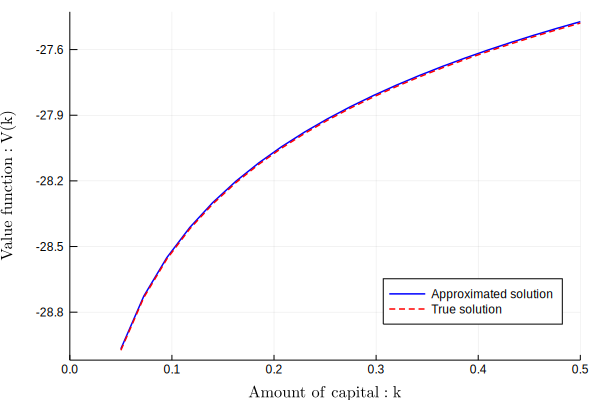

In [10]:
plot(m.kgrid, vfcn0, 
     label ="Approximated solution", 
     line = (1.5, :solid), color ="blue",
     legend=:bottomright)
plot!(m.kgrid, v_true, 
      label = "True solution",
      line = (1.5, :dash), color ="red")

xlabel!(L"\mathrm{Amount\ of\ capital :  k }")
ylabel!(L"\mathrm{Value\  function  :  V(k)} ")
xlims!(0, m.kgrid[end])
#savefig("Fig3_pndp1.pdf")

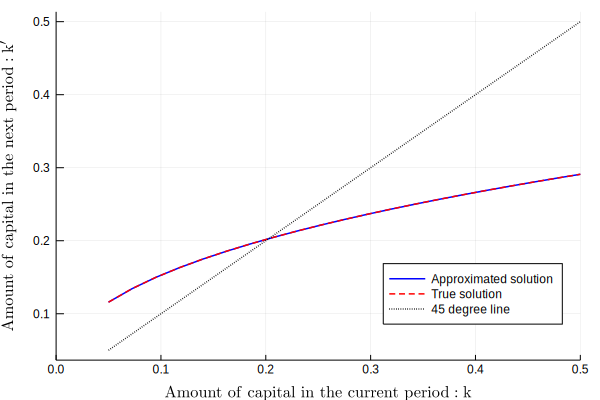

In [11]:
plot(m.kgrid, pfcn0, 
     label ="Approximated solution", 
     line = (1.5, :solid), color ="blue",
     legend=:bottomright)
plot!(m.kgrid, p_true, 
      label = "True solution",
      line = (1.5, :dash), color ="red")

plot!(m.kgrid, m.kgrid, 
      label = "45 degree line",
      line = (1.5, :dot), color="black")
xlabel!(L"\mathrm{Amount\ of\ capital\ in\ the\ current\ period :  k }")
ylabel!(L"\mathrm{Amount\ of\ capital\ in\ the\ next\ period :  k'}")
xlims!(0, m.kgrid[end])
#savefig("Fig3_pndp2.pdf")

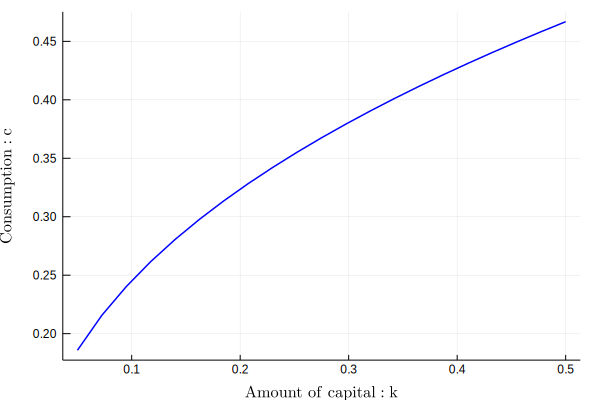

In [12]:
plot(m.kgrid, cfcn, label="", color="blue", line = 1.5)
xlabel!(L"\mathrm{Amount\ of\ capital :  k }")
ylabel!(L"\mathrm{Consumption :  c }")
#savefig("Fig3_pndp3.pdf")

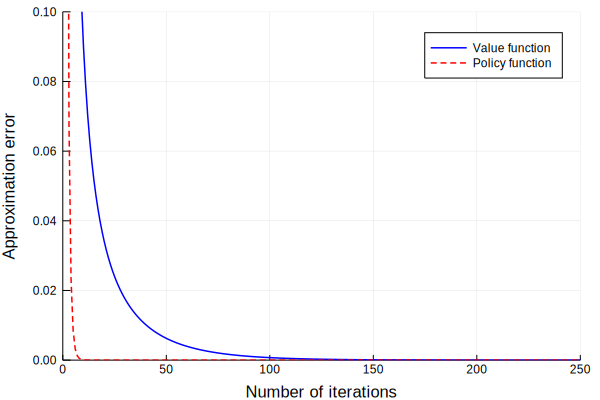

In [13]:
styles = filter((s->begin
                s in Plots.supported_styles()
            end), [:solid, :dash])
styles = reshape(styles, 1, length(styles))

x = 1:m.maxiter
plot(x, dif', line = (1.5, styles), color =["blue" "red"],
     label =["Value function" "Policy function"])
xlims!(0,250)
ylims!(0, 0.1)
ylabel!("Approximation error")
xlabel!("Number of iterations")
#savefig("Fig3_pndp4.pdf")

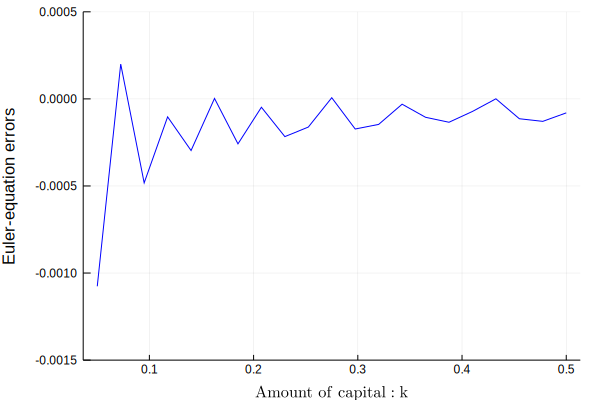

In [14]:
plot(m.kgrid, err,label ="", color = "blue")
ylims!(-15e-4, 5e-4)
ylabel!("Euler-equation errors")
xlabel!(L"\mathrm{Amount\ of\ capital :  k }")
#savefig("Fig3_pndp5.pdf")

In [15]:
err2 = readdlm("err_ddp.txt")
err2 = vec(err2);

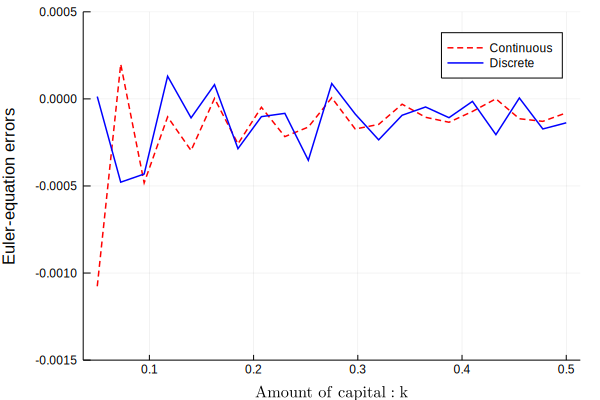

In [16]:
plot(m.kgrid, err, color = "red",line =(1.5, :dash), label ="Continuous")
plot!(m.kgrid, err2, color ="blue", line =(1.5, :solid), label ="Discrete")
ylims!(-15e-4, 5e-4)
ylabel!("Euler-equation errors")
xlabel!(L"\mathrm{Amount\ of\ capital :  k }")
#savefig("Fig3_pndp6.pdf")